# Appendix B - Code


In [6]:
import random as rd
import matplotlib.pyplot as plt
import numpy as np
import math
import time

rd.seed(2021)

In [7]:
## Round a number to two significant figures as requested. 

def round_2(value):

    a_number = value
    significant_digits = 2
    rounded_number =  round(a_number, significant_digits - int(math.floor(math.log10(abs(a_number)))) - 1)
    return rounded_number

In [8]:
## Random Walk simulation
class OptionSimulation:
    '''
    Simulate the price of options

    '''
    def __init__(self,
                initial_price=100, 
                strike_price=105, #strike price is 
                volatility=0.1, 
                risk_free_rate = 0, ### Throughout we will assume zero growth. 
                maturity = 90, #run for 90 days
                change_in_time = 1/365, # a day  
                iterations = 1000):  #default number of iterations is 1000
        '''
        Inputs:

            initial_price (int):        The price of the underlying asset at time 0

            strike_price (int):         The agreed upon strike price at the exercise date. 

            volatility (float):         The volatility of the option that determines the option price

            maturity (int):             Number of random walks to be simulated in one simulation.

            risk_free_rate (float):     The risk free interest that could be earned if the money is put in the bank. 
                                        By default set to 0 for ease of anaylsis.

            change_in_time (float):     The length of a time step in relation to the volatility and risk free rate

            iterations (int):           The number of random walks to estimate. 


        '''
        self.initial_price = initial_price
        self.strike_price = strike_price
        self.volatility = volatility
        self.maturity = maturity
        self.risk_free_rate = risk_free_rate
        self.change_in_time = change_in_time
        self.stock_prices = np.zeros((iterations, self.maturity + 1))
        self.iterations = iterations
        self.expected_value = None
        self.option_price = None



    def simulate(self):

        """
        Simulate the most basic of random walk option pricing models
        Updates the stock prices to a matrix of shape [interations, walks]
        """ 
        #for each walk in the iterations
        for sim in range(self.iterations):

            #initialize the stock price
            self.stock_prices[sim, 0] = self.initial_price

            #for each step here day in the maturity
            for day in range(self.maturity):
                
                #get the stock price by using the formula
                self.stock_prices[sim, day + 1] = self.stock_prices[sim, day] * (
                    1 + self.risk_free_rate * self.change_in_time + self.volatility * np.random.normal(0, self.change_in_time ** 0.5))
    
    
    def visualise(self, image_name):

        # Plot 10 random price walks, showing how the stock price changes with the number of days.
        plt.figure(figsize=(8, 6))

        plt.plot(self.stock_prices[:10].transpose())
        plt.hlines(self.strike_price, xmin = 0, xmax = self.maturity, linestyles = 'dotted', color = 'black')
        plt.text(s ='Strike Price', x = 3, y = self.strike_price + .5, color = 'black')
        plt.xlim(0, self.maturity + 1)  
        plt.xlabel('Number of Days')
        plt.ylabel('Stock Price')

        plt.savefig(f'{image_name}.jpg')
        plt.show() 

    def final_price(self):

        ## calculate the price difference of final day price and strike price and collect earnings if we make any
        self.expected_value = np.mean([max(self.stock_prices[i, -1] - self.strike_price, 0)  for i in range(self.iterations)]) 

        # discount by the growth rate 
        self.option_price = math.e ** (-self.risk_free_rate*(self.maturity/360)) * self.expected_value

    def perfect_foresight(self):

        return np.mean([max(self.stock_prices[i, -45]- self.strike_price, max(self.stock_prices[i, -1] - self.strike_price, 0))  for i in range(self.iterations)]) 



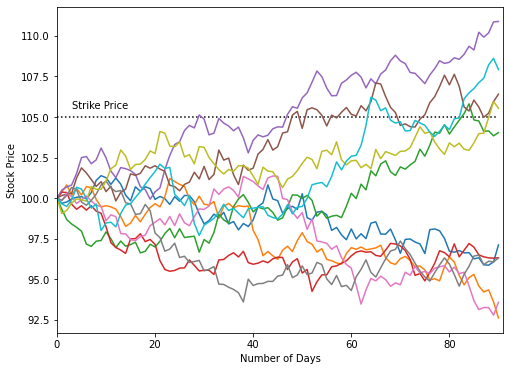

In [9]:
euro_option = OptionSimulation()
euro_option.simulate()
euro_option.visualise('basic_plot')
euro_option.final_price()

In [10]:
print(f"The final price of our European option is {round_2(euro_option.option_price)}")

The final price of our European option is 0.48


In [11]:
## Brute Force approach

# Take a note of the time this takes to run
begin = time.time()

#run an initial number of random walks until the first maturity date
BruteForce = OptionSimulation(iterations = 1000, maturity = 45)
BruteForce.simulate()

#calculate the price of the option at this 
BruteForce.final_price()

#set up a summation for the expected value
expected_value_nested = 0

#for each end price after first time
for price in BruteForce.stock_prices[:,-1]:

    #simulate the next 45 days with the initial price
    resim = OptionSimulation(iterations = 1000, initial_price = price, maturity = 45)

    resim.simulate()
    resim.final_price()

    #check if the expected value at the end of the second time period is higher than on the first
    expected_value_nested += max(price - BruteForce.strike_price, resim.expected_value)

#print the value of the full option
print(f"The option price with two equally space out exercise dates is roughly: {round(expected_value_nested/len(BruteForce.stock_prices[:,-1]), 2)}.\n It took us ~{round_2(time.time() - begin)} seconds to calculate this.")


The option price with two equally space out exercise dates is roughly: 0.45.
 It took us ~140.0 seconds to calculate this.


In [12]:
### ONLY FOR VISUALISING

## Brute Force Visualisation

#run an initial number of random walks until the first maturity date
BruteForceViz = OptionSimulation(iterations = 3, maturity = 45)
BruteForceViz.simulate()

#set up stock price list
full_series = []

#for each end price after first time
for walk in BruteForceViz.stock_prices:

    price = walk[-1]

    #simulate the next 45 days with the initial price
    resim = OptionSimulation(iterations= 10, initial_price = price, maturity = 45)
    resim.simulate()

    #for each subwalk
    for sub_walk in resim.stock_prices:

        #attach the two series
        full_series.append(np.concatenate((walk, sub_walk[1:])))

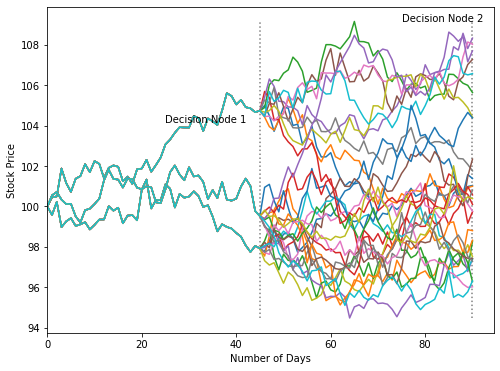

In [13]:
plt.figure(figsize=(8, 6))

plt.plot(np.asarray(full_series).transpose())
plt.vlines(45, ymin = min(np.asarray(full_series).flatten()), ymax = max(np.asarray(full_series).flatten()), linestyle = "dotted", color = 'grey')
plt.text(s ='Decision Node 1', x = 25, y = max(np.asarray(full_series).flatten()) -5, color = 'black')
plt.vlines(90, ymin = min(np.asarray(full_series).flatten()), ymax = max(np.asarray(full_series).flatten()), linestyle = "dotted", color = 'grey')
plt.text(s ='Decision Node 2', x = 75, y = max(np.asarray(full_series).flatten()), color = 'black')
plt.xlim(0)
plt.xlabel('Number of Days')
plt.ylabel('Stock Price')

plt.show()

In [14]:
## Perfect foresight 
PerfectForesight = OptionSimulation(iterations = 1000000)
PerfectForesight.simulate()
round_2(PerfectForesight.perfect_foresight())

0.49

In [15]:
#American Options

American = OptionSimulation(strike_price = 101)
American.simulate()

#get the matrix of randomly walked asset prices S
S = American.stock_prices

#value at each decision node
V = np.maximum(S - American.strike_price, 0)

#get the terminal value at maturity 
V_m = V[:,-1]

#go backwards from the terminal price
for backstep in range(American.maturity -1, 1, -1):

    #get the value at the node one stepped back
    V_t = V[:, backstep]

    #We only use those paths in the money to evaluate the continuation value
    include = V_t > 0

    #fit a function
    fitted = np.polynomial.Polynomial.fit(V_t[include], V_m[include], 10)
    
    # approximate a continuation value with the polynomials
    C = fitted(V_t)

    # If the continuation value is smaller than the current value, we exercise
    exercise = include & (V_t > C)
    
    # update the terminal prices with early exercises 
    V_m[exercise] = V_t[exercise]


print(f"The final value of our American stock price is {round_2(np.mean(V_m))}")

The final value of our American stock price is 1.7
